In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Helper Functions

In [2]:
def add_noise(df, scale):
    noise = pd.DataFrame(np.random.normal(loc=0, scale=scale, size=df.shape), columns=df.columns)

    df_noisy = noise.add(df)

    return df_noisy

In [3]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

# Prepare Data

In [4]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [5]:
# scale spectrum data
data_scale = 10**12
spectrum_train = spectrum_train.multiply(data_scale)
spectrum_test = spectrum_test.multiply(data_scale)

In [6]:
from sklearn.model_selection import train_test_split
# set train and test data

# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 0

# use only if split == 1
# 1 - combine given training and validation data
# 0 - use only training data
combine = 1

# 1 - noise added to training data
# 0 - no noise added
noise_scale = 0.01
noise = 1

if noise:
    if direction:
        temp_train = add_noise(temp_train, noise_scale)
    else:
        spectrum_train = add_noise(spectrum_train, noise_scale)

if not combine:
    if direction:
        X_train = temp_train
        X_test = temp_test
        y_train = spectrum_train
        y_test = spectrum_test
    else:
        X_train = spectrum_train
        X_test = spectrum_test
        y_train = temp_train
        y_test = temp_test
else:
    spectrum = pd.concat([spectrum_train, spectrum_test], axis=0)
    temp = pd.concat([temp_train, temp_test], axis=0)
    if direction:
        X_train, X_test, y_train, y_test = train_test_split(temp, spectrum, test_size=0.3, random_state=101)
    else:
        X_train, X_test, y_train, y_test = train_test_split(spectrum, temp, test_size=0.3, random_state=101)

In [7]:
# create input and output tensors
X = df_to_tensor(X_train)
y = df_to_tensor(y_train)

In [8]:
n_samples, input_size = X.shape
_, output_size = y.shape

In [9]:
input_size

66

# Design Model 
(input size, output size, forward pass)

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_units, num_layers):
        super(Net, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        
        self.hidden_layers = nn.ModuleList()
        
        # Create the hidden layers
        for _ in range(self.num_layers):
            self.hidden_layers.append(nn.Linear(self.input_size, self.hidden_units))
            self.input_size = self.hidden_units
            
        # Output layer
        self.output_layer = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output


In [15]:
model = NeuralNetRegressor(
    module=Net,
    module__input_size = input_size,
    module__output_size = output_size,
    criterion = nn.MSELoss,
    max_epochs = 1000,
    optimizer = torch.optim.Rprop,
    verbose = 1
)

param_grid = {
    'module__hidden_units': [5, 30, 15],
    'optimizer__lr': [0.01],
    'module__num_layers': [2, 3, 4]
}

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error')

# Training Loop

In [16]:
grid_search.fit(X, y)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   103179.4616    96166.3722  0.0190
      2    60087.8566    21069.8418  0.0110
      3    18388.0062    19204.2897  0.0110
      4    16629.7682    16286.0457  0.0121
      5    12846.4859     9944.7320  0.0116
      6     7421.0976     4393.6442  0.0120
      7     2065.6175      675.5928  0.0130
      8      434.4724      355.6839  0.0120
      9      324.8052      289.6773  0.0120
     10      280.3926      269.2740  0.0120
     11      259.4617      250.1236  0.0110
     12      238.5359      227.9035  0.0120
     13      228.0949      226.2159  0.0132
     14      226.9073      224.1168  0.0120
     15      226.3452      223.9522  0.0130
     16      226.0037      223.7920  0.0120
     17      225.6378      223.7706  0.0130
     18      225.2692      223.3617  0.0120
     19      224.7676      222.1408  0.0120
     20      224.3390      222.0852  0.0110
     21      223.9476      222.0

In [ ]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [ ]:
best_params

{'module__hidden_units': 15, 'module__num_layers': 2, 'optimizer__lr': 0.01}

In [ ]:
pred = pd.DataFrame(best_model.predict(df_to_tensor(X_test)))
mse = mean_squared_error(y_test, pred)
print(f'Mean Squared Error of the Best Model: {mse}')

Mean Squared Error of the Best Model: 205.31092281186338


# Plots

### Clean

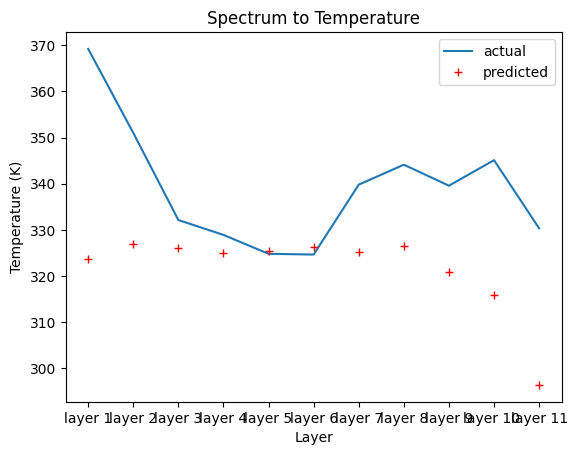

In [ ]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(pred))

actual_np = y_train.values[index]
pred_np = pred.values[index]


plt.plot(y_train.columns, actual_np, label='actual')
plt.plot(y_train.columns, pred_np, 'r+', label='predicted')

if direction:
    plt.title("Temperature to Spectrum")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Spectrum to Temperature")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()

### Noisy

In [ ]:
noisy_test = add_noise(X_test, 0.01)

pred = pd.DataFrame(best_model.predict(df_to_tensor(noisy_test)))

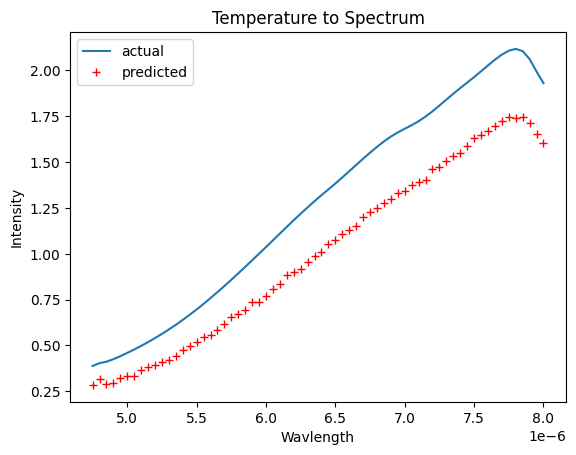

In [ ]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(pred))

actual_np = y_test.values[index]
pred_np = pred.values[index]


plt.plot(y_train.columns, actual_np, label='actual')
plt.plot(y_train.columns, pred_np, 'r+', label='predicted')

if direction:
    plt.title("Temperature to Spectrum")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Spectrum to Temperature")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()